In [1]:
# Import required modules
from satpy import Scene
from datetime import datetime
import glob
import numpy as np

In [2]:
# Read in satellite data
path_sat = '../data/himawari8/'
observation_time = datetime(2020, 8, 1, 5)

# Genereate list of filenames for each Himawari band
filelist = glob.glob(path_sat + "*" + observation_time.strftime("%Y%m%d_%H%M") + "*.DAT")

# Print filenames using for-loop one liner
for f in filelist: print(f)

../data/himawari8/HS_H08_20200801_0500_B07_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B02_FLDK_R10_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B13_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B06_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B15_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B16_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B01_FLDK_R10_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B11_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B12_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B09_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B10_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B04_FLDK_R10_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B08_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B03_FLDK_R05_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B05_FLDK_R20_S0310.DAT
../data/himawari8/HS_H08_20200801_0500_B14_FLDK_R20_S0310.DAT


In [3]:
# Check available datasets
scn = Scene(filelist, reader='ahi_hsd')
scn.available_dataset_names()

['B01',
 'B02',
 'B03',
 'B04',
 'B05',
 'B06',
 'B07',
 'B08',
 'B09',
 'B10',
 'B11',
 'B12',
 'B13',
 'B14',
 'B15',
 'B16']

In [4]:
# Load all bands
scn.load(scn.available_dataset_names())

In [5]:
# Convert a few bands to numpy arrays

B01_1km = scn['B01'].values  # 1 km visible channel
B03_05km = scn['B03'].values  # 0.5 km visible channel
B14_2km = scn['B14'].values  # 2 km infrared channel


In [6]:
# Check their dimenions
print(B01_1km.shape)
print(B03_05km.shape)
print(B14_2km.shape)

(11000, 11000)
(22000, 22000)
(5500, 5500)


In [7]:
# Downscale by skipping pixels in row and col space
B01_2km = B01_1km[::2, ::2]
B03_2km = B03_05km[::4, ::4]

# Check new dimenions
print(B01_2km.shape)
print(B03_2km.shape)


(5500, 5500)
(5500, 5500)


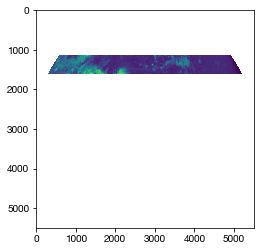

In [8]:
# view the results with imshow
import matplotlib.pyplot as plt

plt.imshow(B01_2km)
plt.show()

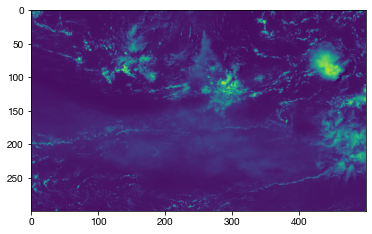

In [9]:
# Note how we only have a 'strip' of data. This is the 3rd sector scan from Himawari.
# Subset the data by rows and cols to see our area of interest
r1, r2 = 1300, 1600 
c1, c2 = 2500, 3000
B01_2km_subset = B01_2km[r1:r2, c1:c2]
B03_2km_subset = B03_2km[r1:r2, c1:c2]
B14_2km_subset = B14_2km[r1:r2, c1:c2]

plt.imshow(B01_2km_subset)
plt.show()

In [10]:
# Now do regridding by averaging pixels using scikit-image
from skimage.transform import downscale_local_mean

B01_2km_avg = downscale_local_mean(B01_1km, (2, 2))  # Takes the average every 2x2 pixels
B03_2km_avg = downscale_local_mean(B03_05km, (4, 4))  # Takes the average every 4x4 pixels

In [11]:
# Check new dimenions
print(B01_2km_avg.shape)
print(B03_2km_avg.shape)

(5500, 5500)
(5500, 5500)


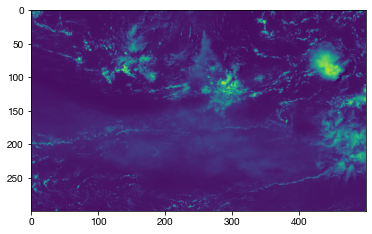

In [12]:
# Subset and view results
B01_2km_avg_subset = B01_2km[r1:r2, c1:c2]
B03_2km_avg_subset = B03_2km[r1:r2, c1:c2]

plt.imshow(B01_2km_subset)
plt.show()

/home/aprata/anaconda3/envs/satpy-env/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/aprata/anaconda3/envs/satpy-env/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/aprata/anaconda3/envs/satpy-env/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_st

(5500, 5500)
(5500, 5500)
(5500, 5500)


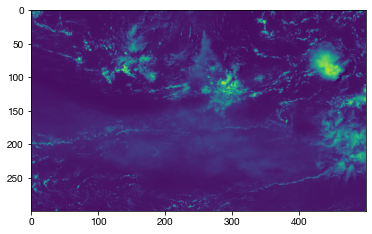

In [13]:
# Another approach for achieving the same result is to use the Satpy NativeResampler:
# If data is higher resolution (more pixels) than the destination area then data is averaged 
# to match the destination resolution. 
# If data is lower resolution (less pixels) than the destination area then data is repeated 
# to match the destination resolution.

# By default the native resampler will sample to the highest resolution of the bands loaded.
# But we can also downscale to the coarests resolution using the following:
lcn = scn.resample(scn.coarsest_area(), resampler='native')
B01_2km_lcn = lcn['B01'].values
B03_2km_lcn = lcn['B03'].values
B14_2km_lcn = lcn['B14'].values

# Check their dimenions
print(B01_2km_lcn.shape)
print(B03_2km_lcn.shape)
print(B14_2km_lcn.shape)

# Subset and view results
B01_2km_lcn_subset = B01_2km_lcn[r1:r2, c1:c2]
plt.imshow(B01_2km_subset)
plt.show()